In [12]:

import json
import csv
import matplotlib.pyplot as plt
import datetime as datetime

import lib.BasicMeasurement as basic
import lib.plot as plot
from lib.Database import Database

In [8]:

source = 'public1000-3/combined-pairs'
measurement = "order_cachebased"
db = Database(source)

### Functions

In [20]:

def load_resolver(ip1, ip2):

  ips = sorted([ip1, ip2], key=lambda x: tuple([int(i) for i in x.split(".")]))
  with open(f"{db.ns_folder(ips[0])}/{measurement}", 'r') as f:
    res = [basic.BasicMeasurement(json.loads(line)) for line in f]
    return [r for r in res if ips[1] in r.get_resolvers()]

In [37]:

def subplot_order_cachebased(data, ax):

  # Make sure basic measurement follows the structure required for this function
  assert data.cs_order_cachebased(), "Measurement not eligible for 'flatten' functions"
  
  # A flatten pattern has 4 stages
  # 1. Cache filling of ns0
  # 2. Probing ns1
  # 3. Cache filling of ns1
  # 4. Probing ns0
  # Consequently, index 0 and 3 concern ns0 and index 1 and 2 concern ns1
  queryplan = data.d['queries']
  ns0 = queryplan[0]['rr']
  ns1 = data.d['queries'][1]['rr']
  
  ns0_color = "blue"
  ns1_color = "red"
  response_label = "Responses"
  logentry_label = "Logentries"
  marker = "x"

  # Plot responses
  delta = data.get_ts_delta() # used to align response and logentry timestamps
  
  # Plot ns0 responses
  ns0_ts = [r['timestamp_sent'] for r in data.d['responses'] if r['resolver'] == ns0] # get timestamps of ns0 responses
  ns0_ts = [t-delta for t in ns0_ts] # normalize response timestamps
  ax.scatter(ns0_ts, [response_label]*len(ns0_ts), marker=marker, color=ns0_color, label=ns0)

  # Plot cache filling of ns0
  num_cache_filling = queryplan[0]['repeat'] # num queries in cache filling stage of ns0
  num_probing = queryplan[3]['repeat'] # num queries in probing stage of ns0
  assert len(ns0_ts) == num_cache_filling + num_probing, "Number of responses does not match number of queries"
  wait_after_first = datetime.timedelta(seconds=queryplan[0]['wait_after']) # padding time after cache filling of ns0
  # Cache filling stage of ns0 is from first query sent to last query sent (should be received!) plus padding time
  ax.axvspan(ns0_ts[0], ns0_ts[num_cache_filling-1]+wait_after_first, alpha=0.5, color=ns0_color, label=f"Cache filling {ns0}")

  # Plot ns1 responses
  ns1_ts = [r['timestamp_sent'] for r in data.d['responses'] if r['resolver'] == ns1] # get timestamps of ns1 responses
  ns1_ts = [t-delta for t in ns1_ts] # normalize response timestamps
  ax.scatter(ns1_ts, [response_label]*len(ns1_ts), marker=marker, color=ns1_color, label=ns1)
  
  # Plot cache filling of ns1
  num_probing = queryplan[1]['repeat']
  num_cache_filling = queryplan[2]['repeat']
  assert len(ns1_ts) == num_cache_filling + num_probing, "Number of responses does not match number of queries"
  wait_after_second = datetime.timedelta(seconds=queryplan[2]['wait_after'])
  ax.axvspan(ns1_ts[num_probing], ns1_ts[-1]+wait_after_second, alpha=0.5, color=ns1_color, label=f"Cache filling {ns1}")

  # Plot Buffer time
  buffer_time = datetime.timedelta(seconds=queryplan[1]['wait_after'])
  # Buffertime is 'buffer_time' seconds before first probing query of ns1
  ax.axvspan(ns1_ts[num_probing]-buffer_time, ns1_ts[num_probing], alpha=0.5, color='green', label="Buffer time")

  # Plot Logentries
  stages = data.order_group_logentries()
  
  # Plotting log entries to first nameserver
  assert stages[0]['rr'] == stages[3]['rr']
  ns0_ts = [e['timestamp'] for e in stages[0]['logentries']] + [e['timestamp'] for e in stages[3]['logentries']]
  ax.scatter(ns0_ts, [logentry_label]*len(ns0_ts), marker=marker, color=ns0_color)

  # Plotting log entries to second nameserver
  assert stages[1]['rr'] == stages[2]['rr']
  ns1_ts = [e['timestamp'] for e in stages[1]['logentries']] + [e['timestamp'] for e in stages[2]['logentries']]
  ax.scatter(ns1_ts, [logentry_label]*len(ns1_ts), marker=marker, color=ns1_color)

  result = data.order_cachebased() 
  result = result if result != None else ["None"]
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  #ax.set_title(f"{'->'.join(result)}")
  ax.set_title(result[0] + r"$\rightarrow$" + result[1])
  #ax.tick_params(labelrotation=30)
  return ax



4


<Axes: title={'center': 'None'}>

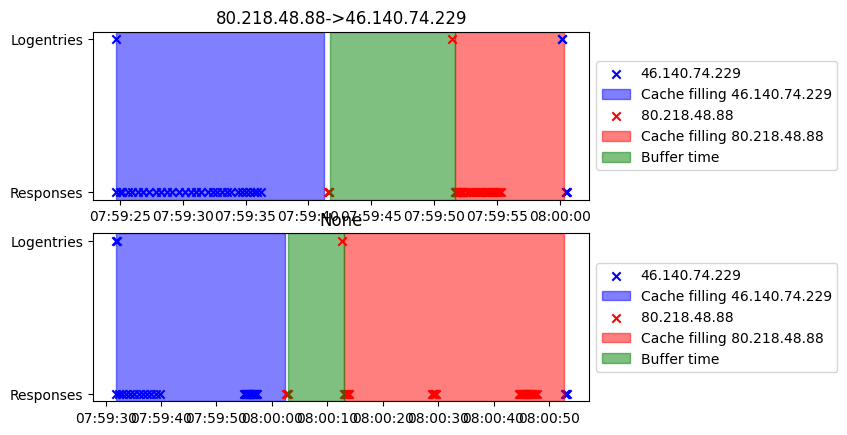

In [29]:

m = load_resolver("46.140.74.229", "80.218.48.88")
print(len(m))

fig, ax = plt.subplots(2, 1)
subplot_order_cachebased(m[2], ax[0])
subplot_order_cachebased(m[0], ax[1])

2


<Axes: title={'center': '62.91.19.67$\\rightarrow$8.8.8.8'}>

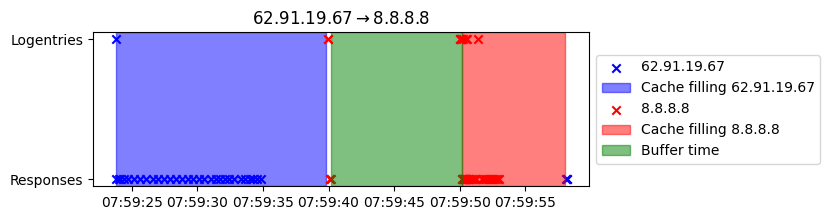

In [38]:

m = load_resolver("8.8.8.8", "62.91.19.67")
print(len(m))

fig, ax = plt.subplots()
fig.set_figheight(2)
subplot_order_cachebased(m[1], ax)